# <b>Feature Selection</b>

In this notebook we use several methods to perform feature selection. In particular:


- Variance Threshold
- PCA
- Random Forest 

As usual we do some preprocessing on the training set adding all the features.

In [1]:
import sys
sys.path.append("../")
from preprocessing.preprocessing import preprocessing
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils import add_all_features

In [2]:
import os
os.chdir('..')
train = pd.read_csv("dataset/original/train.csv")
test = pd.read_csv("dataset/original/x_test.csv")

useTest = True

df = preprocessing(train, test, useTest=useTest)

df, categorical_f = add_all_features(df)

drop_cols1=['target','real_target','sku','Date']
drop_cols_pca = ['sku','size (GM)','scope', 'Date', 'real_target', 'pack', 'brand', 'cluster','target','month','day','year'
            ]
df = df.sort_values('Date')

df_train=df[df.Date < '2019-06-29']
df_train=df_train.fillna(0)



6019it [00:00, 7578.28it/s]
6019it [00:00, 34375.37it/s]
100%|██████████| 43/43 [00:00<00:00, 544.20it/s]


# Variance Threshold

This method removes features with variation below a certain cutoff. The idea is when a feature doesn't vary much within itself, it generally has very little predictive power. 

We use the variance threshold to print out the less informative features.

In [3]:
df_train1=df_train.drop(drop_cols1,axis=1)
feature_selection_variance_model = VarianceThreshold(threshold=.8*(1-.8))
X_selected_features_variance = feature_selection_variance_model.fit_transform(df_train1)

mask = feature_selection_variance_model.get_support() 

print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", df_train1.columns[mask])
print("      Deleted Features = ", df_train1.columns[~mask])

Reduced data set shape =  (5719, 24)
     Selected features =  Index(['pack', 'size (GM)', 'brand', 'price', 'POS_exposed w-1',
       'volume_on_promo w-1', 'sales w-1', 'scope', 'moving_average_20',
       'exp_ma', 'lag_target_25', 'lag_target_50', 'month', 'day', 'year',
       'days_to_christmas', 'heavy_light', 'partial_sales', 'pos_lagged_2',
       'cluster', 'week_of_the_year', 'seasons', 'tot_cost', 'Corr'],
      dtype='object')
      Deleted Features =  Index(['increment'], dtype='object')


# Random Forest for Feature Selection

In [4]:
y=df_train.real_target
df_train2=df_train.drop(drop_cols1,axis=1)
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(df_train2,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. feature 10 exp_ma (0.246881)
2. feature 8 moving_average_20 (0.239596)
3. feature 6 sales w-1 (0.231265)
4. feature 17 heavy_light (0.061149)
5. feature 11 lag_target_25 (0.054632)
6. feature 1 size (GM) (0.040444)
7. feature 3 price (0.026506)
8. feature 12 lag_target_50 (0.025391)
9. feature 23 tot_cost (0.017235)
10. feature 7 scope (0.016719)
11. feature 20 cluster (0.014687)
12. feature 9 increment (0.005155)
13. feature 2 brand (0.003537)
14. feature 16 days_to_christmas (0.002362)
15. feature 21 week_of_the_year (0.002175)
16. feature 13 month (0.002125)
17. feature 4 POS_exposed w-1 (0.001973)
18. feature 5 volume_on_promo w-1 (0.001931)
19. feature 24 Corr (0.001532)
20. feature 19 pos_lagged_2 (0.001498)
21. feature 18 partial_sales (0.001023)
22. feature 22 seasons (0.000646)
23. feature 14 day (0.000596)
24. feature 15 year (0.000484)
25. feature 0 pack (0.000456)


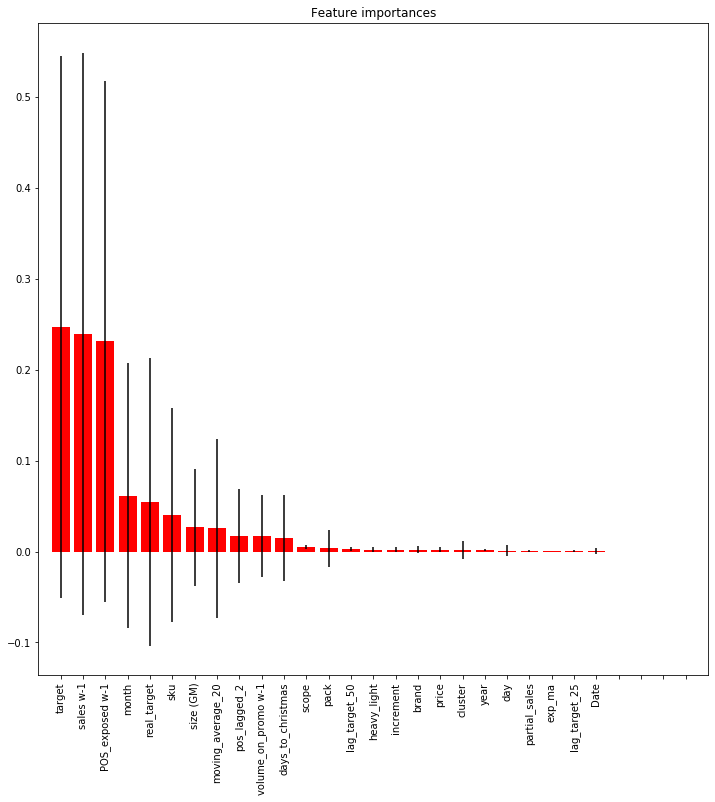

In [5]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(df_train2.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], df_train2.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(df_train2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), df_train.columns[indices],rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()

# PCA

In [6]:
df_train_pca=df_train.drop(drop_cols_pca,axis=1)
X_std = StandardScaler().fit_transform(df_train_pca)
feature_selection_pca_model = PCA()
fitted_model = feature_selection_pca_model.fit(X_std)
f_m=fitted_model.transform(X_std)

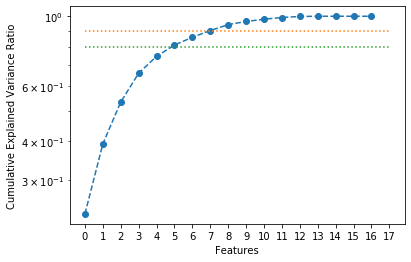

In [7]:
plt.semilogy(fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0, 18, 1));
plt.plot([0, 17], [.9, .9], ':')
plt.plot([0, 17], [.8, .8], ':')
plt.xlabel("Features")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()

In [8]:
n_pcs= fitted_model.components_.shape[0]

most_important=[]
for i in range(n_pcs):
    most_important.append(np.abs(fitted_model.components_[i]).argmax())
    #fitted_model.components_[:,most_important[i]]=0 se vogliamo droppare la feature una volta presa in 
                                                        #considerazione



#most_important = [np.abs(fitted_model.components_[i]).argmax() for i in range(n_pcs)]


initial_feature_names = [df_train_pca.columns.values]

most_important_names = [initial_feature_names[0][most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
print (df)

       0                    1
0    PC0            sales w-1
1    PC1                price
2    PC2     week_of_the_year
3    PC3        lag_target_50
4    PC4            increment
5    PC5            increment
6    PC6          heavy_light
7    PC7              seasons
8    PC8              seasons
9    PC9  volume_on_promo w-1
10  PC10        lag_target_25
11  PC11      POS_exposed w-1
12  PC12        lag_target_50
13  PC13    moving_average_20
14  PC14                price
15  PC15               exp_ma
16  PC16    days_to_christmas
